# Hands-On Assignment 2

As we saw in Module 2, machine learning is about optimizing over a loss.
How well a machine learning model performs depends on both the hypothesis and loss function that we choose to use.
This general framework goes under the name of *[empirical risk minimization](https://en.wikipedia.org/wiki/Empirical_risk_minimization)*.

In this assignment, we will walk you through the basic steps of empirical risk minimization: the optimization problem at the heart of most modern-day machine learning systems.
We will use a simple motivating example for an end-to-end demonstration: predicting whether a patient with a given antigen test value is infected with Covid-19.
Using the same synthetic Covid-19 dataset you worked with in Hands-On Assignment 1,
we will train a simple [classifier](https://en.wikipedia.org/wiki/Statistical_classification) that predicts that an individual is infected with Covid-19 if and only if their test value is above a certain threshold.

This assignment is divided into three parts:
1. We will first set up a basic empirical risk minimization problem.
2. Next, we will find a hypothesis that results in a small loss.
3. Finally, we will evaluate our solution and the associated risks of deployment.

## Part 1: Setting up the Problem

In this part we will setup the empirical risk minimization problem we wish to solve, by:
 - Defining our variables of interest.
 - Choosing a "hypothesis class" $ \mathcal{H} $, or space of possible solutions, that we will search.
 - Selecting a "loss function" $ L $ that will be minimized by our learned solution, thus encoding our objective.

### Empirical Risk Minimization - The Big Picture

Empirical risk minimization is about trying to come up with a function (usually called a *hypothesis*) that can make correct predictions as often as possible.
The more our hypothesis is correct, the lower the *risk* of that hypothesis.
A hypothesis that is always correct has zero risk.

But in real life, it's almost always impossible to make something that is always correct.
(If we could, there would be no point in machine learning.)
It's also impossible for us to always know when our hypothesis is right or wrong (imagine trying to predict something for every person in the world (past, present, and future)).

So since we can't compute the true risk of a hypothesis, we instead approximate it by computing an *empirical risk*.
To do this, we narrow down our set of data points from every possible data point to a known set of training data.
We can then compute our average loss over our known data to compute our empirical risk.

### Empirical Risk Minimization - Mathematical Formalism

Now, let's put our intuition from the previous section into math.

Empirical risk minimization is the **minimization** (over several possible hypotheses $\mathcal{H}$) of the expected loss (i.e. *risk*) of a hypothesis $ h $ with the data $ Z $:
$$
\min_{h \in \mathcal{H}} \mathbb{E}_Z \Big[ L(Z, h) \Big]
$$

Here we are taking the [expectation](https://en.wikipedia.org/wiki/Expected_value) ($ \mathbb{E} $) over all possible values of the data.
If you haven’t seen expectation before, we will discuss it in detail in a future module.
But for now, you can think of expectation as the average value we would get if we randomly sampled infinite data points.
For example, if we fairly picked random numbers between 1 and 99 (inclusive),
then the expected value (expectation) would be 50.
You can make a small Python program to try it out yourself.

Using a finite set of empirical data $ Z = \{z_1, z_2, z_3, ..., z_N \} $, we can say that:
$$
\mathbb{E}_{Z} \Big[ L(Z, h) \Big] \approx \frac{1}{N} \sum_{i=1}^N L(z_i, h)
$$

Note that in our equation, we are dividing the loss by the number of data points, $ N $.
This allows us to compute the *expected loss*,
which is the amount that we expect each prediction to be off by.
Another common way of using loss, that you may have seen in class,
is using the *total loss*.
The total loss is computed the same as the expected loss, but does not average over all data points (doesn't divide by $ N $).
Using either the expected or total loss leads to the same answer for this problem.
In the future, we will discuss when using one would be more appropriate than the other.

### A Motivating Example using Synthetic Covid-19 Data

As a motivating example, let's try to use the synthetic Covid-19 data used in HO1 to predict whether a patient has Covid-19.
For this task, we are given previous examples of asymptomatic patients (and their Covid-19 infection status),
and we are going to assume that these examples accurately represent patients that we may see in the future.
This assumption we are making is called the [i.i.d. assumption](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables),
and it is one of the cornerstones of many machine learning algorithms.
The independent and identically distributed (i.i.d.) assumption assumes that all random variables (each patient in this example),
are *independent* (one patient being infected does not affect whether another patient is infected),
and *identically distributed* (future patients will have similar features to the patients we have already seen).

Let's load this set of previous examples, included in this repository as `synthetic_covid_data.csv`, using Python and briefly consider its contents:

In [1]:
import matplotlib
import numpy
import pandas

from matplotlib import pyplot

# Read data from the given csv file to a Pandas dataframe.
covid_data = pandas.read_csv('synthetic_covid_data.csv', index_col = 0)

# Show some basic column and type information.
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   infected              5000 non-null   bool   
 1   symptomatic           5000 non-null   bool   
 2   days_before_symptoms  138 non-null    float64
 3   titer                 5000 non-null   int64  
dtypes: bool(2), float64(1), int64(1)
memory usage: 127.0 KB


Inspecting the dataframe information, we see that this dataset contains the following columns:
 - `infected` (as a boolean) - whether a patient had Covid-19.
 - `symptomatic` (as a boolean) - whether a patient developed symptoms.
 - `days_before_symptoms` (as a float) - how many days after testing the patient developed symptoms, if they did.
 - `titer` (as an integer) - how many times bodily fluids could be diluted before antigen was no longer detectable.

We also note that Pandas tells us that `days_before_symptoms` contains mostly null/undefined content (only 138 non-null values).

We can get an impression of the ranges and statistics of numerical columns by calling `covid_data.describe()`:

In [2]:
# Describe numerical column statistics.
covid_data.describe()

,days_before_symptoms,titer
count,138.000000,5000.00000
mean,5.405797,3.21480
std,3.877010,8.30552
min,0.000000,0.00000
25%,2.000000,0.00000
50%,5.000000,0.00000
75%,9.000000,1.00000
max,13.000000,45.00000


### Defining Variables of Interest: Features and Labels

The first step in empirical risk minimization is to define our features ($ X $) and labels ($ Y $).

The features (as discussed in HO1) are the meaningful numbers that we associate with a data point.
In our Covid-19 data, we have three columns that can be used as features: `symptomatic`, `days_before_symptoms`, and `titer`.
To keep things simple, we will only use one feature in this assignment: the `titer` column.
Although we will only use one feature column in this assignment, most machine learning models use tens, hundreds, thousands, or even more feature columns.

For our label, we will use the `infected` column.
The label assigns each data point to a specific class (in this case, *infected* or *not infected*).
Labels can take a wide range of values, for example if you are trying to classify the subject of an image there can be many possible labels: dog, cat, person, etc.
In this assignment we are focusing on [binary classification](https://en.wikipedia.org/wiki/Binary_classification),
where the label can only be True (1) or False (0).

Together, the features ($ X $) and labels ($ Y $) define our dataset $ Z $:
$$
Z = (X, Y)
$$

In [3]:
# Extract features and labels from the dataframe.
Y_values = covid_data['infected']
X_values = covid_data['titer']

#### Briefly Interpreting the Data

In this dataset, a "titer" value roughly measures the concentration of a specific antigen produced by a Covid-19 infection.
Having run `covid_data.describe()`, we see that titer values in this dataset are integers ranging from `0` to `45`,
with at least 75% of examples having titer values of `1` or less.
We can visualize the relationship between titer and Covid-19 infections in our data by plotting the sampled frequency of Covid-19 infection vs titer values
(i.e., for each titer value, plot the percent of patients that have that titer value and are infected):

In [ ]:
def plot_infection_probability_vs_titer(frame):
    """
    Plot the infected rate of Covid-19 vs titer value.
    """

    # Get all the possible titer values in a list.
    titer_values = list(range(frame['titer'].min(), frame['titer'].max() + 1))
    infected_rate = []

    for titer_value in titer_values:
        infected_count = len(frame[(frame['titer'] == titer_value) & frame['infected']])
        count = len(frame[(frame['titer'] == titer_value)])

        if (count == 0):
            # Matplotlib will ignore None/NaN values.
            infected_rate.append(None)
        else:
            infected_rate.append(infected_count / count)

    pyplot.plot(infected_rate)
    pyplot.title('Sample Frequency of Covid-19 Infection vs Titer Value')
    pyplot.xlabel('Titer')
    pyplot.ylabel('Precentage Infected')

plot_infection_probability_vs_titer(covid_data)

In the above graph we can see, perhaps surprisingly,
that many patients with low (but not zero) titer values are actually infected.
The graph shows that at a titer value of 0, we don't see any infected individuals;
at a titer value of 10, about 100% if patients are infected;
at a titer value of 20, the infection rate drops to around 20%;
and finally at a titer value of 40, the infection rate climbs back up to around 80%.
Unfortunately, biology is rarely very simple.

To make more sense of our data, we can separate out the data into infected and uninfected individuals.
Specifically, we can see what percentage of each population (infected/uninfected) exist at each titer value.

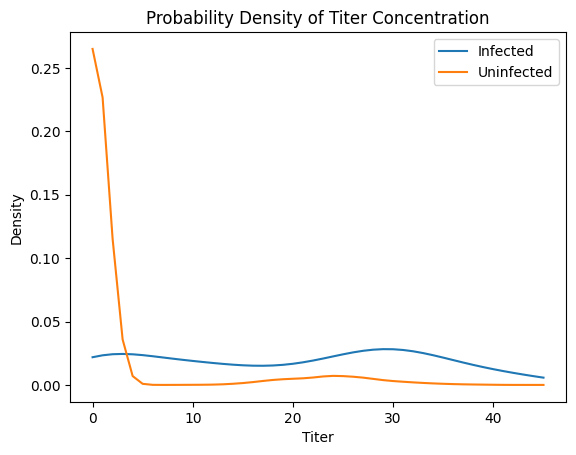

In [4]:
def plot_conditional_probability_density_functions(frame):
    """
    Plot probability density of titer value conditioned on Covid-19 infection.
    """

    titer_values = list(range(frame['titer'].min(), frame['titer'].max() + 1))
    infected = frame[frame['infected']]['titer']
    uninfected = frame[~frame['infected']]['titer']

    pyplot.title('Probability Density of Titer Concentration')
    pyplot.xlabel('Titer')
    infected.plot(kind = 'density', label = 'Infected', ind = titer_values)
    uninfected.plot(kind = 'density', label = 'Uninfected', ind = titer_values)
    pyplot.legend()

plot_conditional_probability_density_functions(covid_data)

Looking at this graph, we can discover some important details about our data.
While most uninfected individuals have very low titer values (under 5),
some small percentage of (isoantigenic) uninfected individuals have reasonable high titer values (widely distributed around 25).
Meanwhile, infected individuals appear to belong to two groups:
one with relatively small titer values (less than 10) and one with much higher titer values (centered around 30).

### Choosing a Hypothesis Class to Search

Now that we have explored our data, it is time to try and make predictions.

Recall that we wish to predict patients' labels $ Y = \{ y_1, y_2, ..., y_N \} $ from patients' features $ X = \{ x_1, x_2, ..., x_N \} $.
That is, our task is to predict each $ y_i $ from each $ x_i $, approximating the true mapping $ f $ such that
$$
\forall i, \quad f(x_i) \mapsto y_i
$$

Since we can never expect to find $ f $ in a real-life problem (since $ f $ is a theoretically perfect predictor),
we will use different hypotheses to approximate it.
A hypothesis is just a function that maps features to a label.
We will denote a general hypothesis with the variable $ h $.
Since we cannot guarantee our hypothesis, $ h $, is always correct,
we denote its output with $ \hat{Y} $ (pronounced "Y-hat").
We say that $ Y $ is the "true label" and $ \hat{Y} $ is the "predicted label".
$$
\forall i, \quad h(x_i) \mapsto \hat{y}_i
$$

Note that we will often relax our notation so that the input to a hypothesis function can either be a single data point ($ h(x_i) \mapsto \hat{y}_i $) or many data points ($ h(X) \mapsto \hat{Y} $).

#### An Example Hypothesis

As a simple example of a hypothesis $ h $,
we might predict $ \hat{y}_i = 1 $ if and only if $ x_i $ is odd.
It turns out that this hypothesis is correct more often than random guessing (which would yield 50% accuracy) ... but this doesn't seem like a principled hypothesis for the task at hand
(we just got lucky)!

In [5]:
def is_odd(feature_value):
    """
    An example hypothesis that guesses True (1) if the input is odd.
    """

    return feature_value % 2

# Note that Pandas understands how to do "% 2" on an entire series,
# so our hypothesis function works for single values and Pandas series.
Y_predicted = is_odd(X_values)

accuracy = sum(Y_values == Y_predicted) / len(covid_data)
print(f"The accuracy of predicting Ŷ = 1 iff X is odd is {accuracy * 100}%.")

The accuracy of predicting Ŷ = 1 iff X is odd is 73.82%.


#### An Example Hypothesis Class

Having only a single possible hypothesis is not very interesting or useful.
Instead, we want to try out and evaluate multiple different hypotheses.
When we group together multiple hypotheses, we call this a *hypothesis class*, denoted by $ \mathcal{H} $.

Let's consider a class of two competing hypotheses:
$ h_0 $ that predicts $ \hat{Y} = 0 $ for all examples,
and $ h_1 $ that always predicts $ \hat{Y} = 1 $.
$$
\mathcal{H} = \Big\{ h_0, h_1 \Big\}
$$
where
$$
\forall X, \quad h_0(X) = 0 \quad h_1(X) = 1
$$
Note that both of these hypotheses are independent of $ X $ ($ X $ does not affect what value the hypotheses predict).

Now that we have two possible hypotheses,
we can conduct experiments to compare them on our data and select the hypothesis that performs the best.
Since only $ \approx $ 5% of individuals in our dataset are Covid-19 positive,
$ h_0 $ will match the true mapping $ f $ on 95% of examples (while $ h_1 $ is only correct 5% of the time).
If we decide the best hypothesis using maximum accuracy,
then $ h_0 $ will look like the best hypothesis and we will always predict that patients are not infected with Covid-19.

Obviously, this class of hypotheses is too naïve and we need a richer hypothesis space to search.

#### A Parametric Hypothesis Class

If we look back to our naïve hypothesis class $ \mathcal{H} = \{h_0, h_1\} $,
we can generalize these hypotheses a bit if recognize that both $ h_0 $ and $ h_1 $ are *threshold* classifiers.
That is, the value of each function can be expressed in terms of a comparison of $ X $ to some *threshold* value:
\begin{align*}
    h_0(X) &= \begin{cases} 1 & X > \infty \\
                            0 & X \leq \infty \end{cases} \\
    h_1(X) &= \begin{cases} 1 & X > -\infty \\
                            0 & X \leq -\infty \end{cases}
\end{align*}
In this case, our threshold values were the extreme ends of the spectrum: $ \infty $ and $ -\infty $.

Now what if, instead of these extreme threshold values, we choose a more meaningful value like `20`?
\begin{align*}
    h(X) &= \begin{cases} 1 & X > 20 \\
                          0 & X \leq 20 \end{cases}
\end{align*}

Now, we can also abstract out the specific threshold value for a variable, $ \theta $:
\begin{align*}
    h(X, \theta) &= \begin{cases} 1 & X > \theta \\
                                  0 & X \leq \theta \end{cases}
\end{align*}
We can recover all of our previous hypothesis using this more general form:
\begin{align*}
    h(X, \infty) \\
    h(X, -\infty) \\
    h(X, 20)
\end{align*}

We can even apply our new general hypothesis to our Covid-19 data.
Let $h(X, \theta)$ predict that a patient is infected with Covid-19 ($ \hat{Y} = 1 $) if and only if `titer` $ X $ is above the threshold value $ \theta $:
$$
    h(X, \theta) = \begin{cases}
    1 & X > \theta  \\
    0 & X \leq \theta
    \end{cases}
$$

Since we now have a general and parameterized hypothesis function,
we can use it to define *all possible hypotheses* our function can represent.
This set of all possible hypotheses is called a "hypothesis space"
(you can think of it as a more general form of a hypothesis class).
Letting $ \theta $ be all possible real numbers, $ \mathbb{R} $, we can create our hypothesis space $ \mathcal{H} $:
$$
    \mathcal{H} = \Big\{h(\cdot, \theta) ~\colon~ \theta \in \mathbb{R} \Big\}
$$
Where the $ \cdot $ (dot) represents any input value.

Because each such threshold classifier is uniquely determined by its threshold value $\theta$, we say that this hypothesis space is *parameterized* by $\theta$.
This means that the original optimization problem may be written as an optimization over $ \theta $,
where we slightly abuse notation to rewrite $ L $ as a function of $ \theta $:
$$
\min_{h\in\mathcal{H}} \mathbb{E}_Z \Big[ L(Z, h) \Big] =  \min_{\theta} \mathbb{E}_Z \Big[ L(Z, \theta) \Big]
$$

It is very common in machine learning to choose hypothesis classes that are parameterized by numerical variables,
this makes it easier to search over with a computer algorithm.

<h3 style="color: darkorange";>★ Task 1.A</h3>

Complete the function below that implements the threshold hypothesis function $ h(x, \theta) $ described above.

In [6]:
def threshold_hypothesis(feature, theta):
    """
    Our thresholding hypothesis function.
    Predict True if x > theta, and False otherwise.

    Args:
      feature: A scalar "titer" value.

    Returns:
      ŷ: A boolean.
    """
    
    return feature > theta

### Selecting a Loss Function to Minimize

In general, it is not possible to learn the true mapping of data to labels, $ f $, exactly.
In fact, there may be no $ \theta $, or no $ h \in \mathcal{H} $, such that $ h = f $.
It could even be possible that 
$ f $ is not even a true *function*!
There could be two patients with the same features but different infection labels,
making it impossible for $ f $ to actually exist.

Instead, we want to choose an $ h \in \mathcal{H} $ that closely approximates the true mapping $ f $.
Mathematically, we introduce a ["loss" function](https://en.wikipedia.org//wiki/Loss_function) that imposes some
[divergence](https://en.wikipedia.org/wiki/Divergence_(statistics)) between $ h $ and $ f $ and seek to minimize this loss.
Essentially, we want a function (a loss function) that can tell us how well a hypothesis performs
(higher loss values are typically bad and a zero loss means our hypothesis matches the data exactly).
Minimizing a loss function is the central task in [mathematical optimization](https://en.wikipedia.org/wiki/Mathematical_optimization),
and is thus central to machine learning.

Though the world of loss functions is vast and theoretically rich,
one simple loss function for binary classifiers is "Zero-One" loss.
Zero-One loss outputs a zero loss (score) when our hypothesis, $ h $, and the true label mapping, $ f $, agree on a given example $ (x_i, y_i) $,
and a one loss (score) otherwise.
$$
    L(Z, \theta) = \begin{cases}
    0 & h(X, \theta) = Y \\
    1 & \text{otherwise}
    \end{cases}
$$

Minimizing Zero-One loss corresponds to maximizing the accuracy of a binary predictor, i.e.,
minimizing the number of times our hypothesis disagrees with the true labels makes our predictor better.

<h3 style="color: darkorange";>★ Task 1.B</h3>

Complete the function below which computes the Zero-One loss for the given hypothesis and theta on the given example.

In [7]:
def zero_one_loss(feature, label, hypothesis, theta):
    """
    Zero-One Loss on a single example (feature, label), as a function of hypothesis and theta.

    Args:
      feature: A scalar "titer" value.
      label: A boolean value corresponding to actual Covid-19 infection.
      hypothesis: A function of (x, theta) that maps to predicted boolean label ŷ.
      theta: A scalar titer threshold.

    Returns:
      0 or 1
    """
    return 0 if hypothesis(feature, theta) == label else 1

## Part 2: Solving the Problem

Now that we have formalisms for hypotheses and loss functions,
we will work on finding the best hypothesis/parameters to solve our problem.
The first step will be to evaluate how well a hypothesis and parameter are performing according to our loss function on our data.
To do that, we can compute an expected loss (the mean loss over all data points):
$$
\mathbb{E}_{Z} \Big[ L(Z, h, \theta) \Big] = \frac{1}{N} \sum_{i = 1}^N L(z_i, h, \theta)
$$

<h3 style="color: darkorange";>★ Task 2.A</h3>

Complete the function below which calculates the average loss on the given examples (`features` and `labels`) as a function of the hypothesis and $ \theta $.

In [9]:
def expected_loss(features, labels, loss_function, hypothesis, theta):
    """
    Evaluates the average loss of the given hypothesis/theta over all examples.

    Args:
      features: the column of X feature (titer) values from empirical data.
      labels: the column of Y label (infection) values from empirical data.
      loss_function: A loss function.
      hypothesis: A function of (x, theta) that maps to the predicted label ŷ.
      theta: A scalar titer threshold.

    Returns:
      A scalar.
    """

    return sum([loss_function(feature, label, hypothesis, theta) for feature,
                label in zip(features, labels)]) / len(features)

Since our example is simple, we can visualize the "loss landscape" (empirical loss as a function of $ \theta $) directly.

**The following step depends on Tasks 1.A, 1.B, and 2.A.**

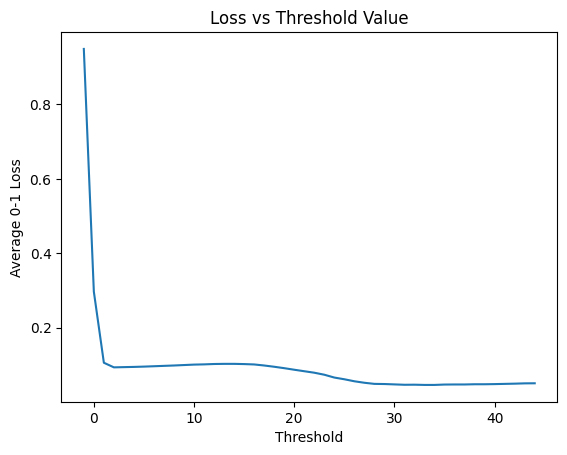

In [10]:
# Possible threshold values (e.g. possible titer values).
possible_thetas = list(range(X_values.min() - 1, X_values.max()))

def evaluate_losses(features, labels, loss_function, expected_loss, hypothesis):
    """
    Return a list of expected losses mapped from a list of possible theta values.
    """

    # empirical loss for each threshold value
    losses = []
    for theta in possible_thetas:
        losses.append(expected_loss(features, labels, loss_function, hypothesis, theta))

    return losses

def plot_loss_landscape():
    """
    Plot expected loss vs threshold value.
    """

    pyplot.plot(possible_thetas, evaluate_losses(X_values, Y_values,
                                                 zero_one_loss, expected_loss,
                                                 threshold_hypothesis))
    pyplot.title('Loss vs Threshold Value')
    pyplot.xlabel('Threshold')
    pyplot.ylabel('Average 0-1 Loss')

plot_loss_landscape()

Again, since our example is simple, we may find the loss-minimizing value of $\theta$ by performing a direct search.

#### Brute-Force Search

There are many optimization algorithms used in machine learning, each with countless tweaks and variations.
One of the more famous methods, gradient descent, we will learn about later in this course.
Nonetheless, **many** optimization algorithms are applicable to our current problem of empirical risk minimization;
in some cases, more principled algorithms (such as convex optimization methods) will yield superior results, depending on the structure of the problem.
To focus on the conceptual underpinnings of empirical risk minimization, here we will start with the simplest of algorithms: brute-force search.
That is, we will compare all possible hypotheses (values of theta) and select the one that minimizes empirical loss.
A brute force search is not always possible (like when there are infinite thetas), but in our specific case there are only so many possible integer titer values.

<h3 style="color: darkorange";>★ Task 2.B</h3>

Complete the function below which calculates the index of the minimum of a given loss:

In [11]:
def index_of_minimum(list_of_values):
    """
    Return the index of minimum value from a list of values.
    If there are multiple items that share the same minimum value,
    then return the lowest index.

    Args:
      list_of_values: A list or array.

    Return:
      An integer index or None if the list is empty.
    """

    return list_of_values.index(min(list_of_values)) if len(list_of_values) > 0 else None

### Result: Learned Threshold Value

According to the average Zero-One loss, what is the optimal threshold titer above which to predict an individual has Covid-19?
The function bellow will finally answer this question.

**This step depends on the previous tasks.**

In [12]:
def brute_force_minimize(possible_thetas, index_of_minimum, features, labels,
                         loss_function, expected_loss, hypothesis):
    best_index = index_of_minimum(evaluate_losses(features, labels, loss_function,
                                                  expected_loss, hypothesis))
    return possible_thetas[best_index]

print(
    "Optimal threshold theta for raw accuracy: ",
    brute_force_minimize(
        possible_thetas, index_of_minimum,
        X_values, Y_values, zero_one_loss, expected_loss, threshold_hypothesis
    )
)

Optimal threshold theta for raw accuracy:  33


## Part 3: Assessing Risk

In this part, we will learn how to evaluate our solution and consider the associated risks of deployment.
In general, each of the steps we went through in previous parts are non-trivial and raises questions that are the subject of active research.
For example:
 - Is our selection of variables appropriate, or do they induce bias in our predictor?
 - What loss functions naturally encode our objectives? Which have mathematical advantages? Which introduce systematic risks?
 - What algorithms are effective in which settings, and what theoretical results can we prove regarding speed, efficiency, or safety?
 - How do we use existing data effectively, again without introducing bias or systemic errors in our solutions?
 - Can our algorithms scale to larger datasets?
 - Can we choose algorithms that can guarantee our results are good enough?

While we have found the threshold titer value that minimizes Zero-One loss and therefore maximizes accuracy,
accuracy (especially evaluated only on the data used for training) is not necessarily the best quantity to optimize.
For example, our Covid-19 data only has about 5% of patients that are infected.
Predicting False for all data points would give an accuracy of 95%.
The accuracy may be high, but the predictor is useless.

Additionally, sometimes we care about certain types of errors more than others.
Consider the following use for our titer-threshold classifier: we wish to screen visitors for entry to a ward of immunocompromised patients.
If our classifier makes a mistake, we would rather it error on the side of caution and predict that someone has Covid-19 when they actually do not.
This way even if we made an error, we protected the immunocompromised patients.
In this example, optimizing for accuracy alone is not the best measure of utility.

### Binary Classification Errors

For binary classifiers, there are several types of prediction outcomes that comprise a "contingency table" or [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix) and which are worthy of dedicated names:

<center><img src="confusion-matrix.png"/></center>
<center style='font-size: small'>Image courtesy of <a href='https://en.wikipedia.org/wiki/Confusion_matrix'>Wikipedia</a></center>

 - True Positives (TP) -- Also called a "hit". Represent instances that were correctly classified as positive/true.
 - True Negatives (TN) -- Also called a "correct rejection". Represent instances that were correctly classified as negative/false.
 - False Positives (FP) -- Also called a "Type I Error" or "false alarm". Represent instances that were incorrectly classified as positive/true.
 - False Negatives (FN) -- Also called a "Type II Error" or "miss". Represent instances that were incorrectly classified as negative/false.

From a confusion matrix, there are many different metrics you can compute
(all telling you different things about your classifier and the dataset):

| Metric                     | Definition                   |
| -------------------------- | ---------------------------- |
| True Positive Fraction     | $$ \Pr(\hat{Y}=1, Y=1)   $$  |
| False Positive Fraction    | $$ \Pr(\hat{Y}=1, Y=0)   $$  |
| True Negative Fraction     | $$ \Pr(\hat{Y}=0, Y=0)   $$  |
| False Negative Fraction    | $$ \Pr(\hat{Y}=0, Y=1)   $$  |
| True Positive Rate         | $$ \Pr(\hat{Y}=1 \mid Y=1) $$   |
| False Positive Rate        | $$ \Pr(\hat{Y}=1 \mid Y=0) $$   |
| True Negative Rate         | $$ \Pr(\hat{Y}=0 \mid Y=0) $$   |
| False Negative Rate        | $$ \Pr(\hat{Y}=0 \mid Y=1) $$   |

Let's walk through some of these metrics.

"True Positive Fraction" ($ \Pr(\hat{Y}=1, Y=1) $) is the probability that both our prediction, $ \hat{Y} $, and true label, $ Y $, are positive/true/1.
Therefore, it would be the number of true positives over the total number of samples:
$$
\mathrm{True Positive Fraction} = TP / N
$$

"True Positive Rate" ($ \Pr(\hat{Y}=1 | Y=1) $) is the probability that the predicted label, $ \hat{Y} $, is positive *given* (conditioned on) the true label being positive.
Therefore, it would be the number of true positives over the total number actual positives:
$$
\mathrm{True Positive Rate} = TP / (TP + FN)
$$

Be aware that most of these metrics have different names in different fields.
For example, "True Positive Rate" is also called "recall", "sensitivity", and "probability of detection".

<h3 style="color: darkorange";>★ Task 3.A</h3>

Complete the following functions, which calculate the frequencies of certain outcomes for a titer-threshold classifier on our empirical data.
Refer to the above table and descriptions.

In [15]:
def true_positive_fraction(features, labels, hypothesis, theta):
    """
    Returns Pr(Ŷ = 1, Y = 1) for the given hypothesis and theta.

    Args:
      features: the column of X feature (titer) values from empirical data.
      labels: the column of Y label (infection) values from empirical data.
      hypothesis: A function of (x, theta) that maps to the predicted label ŷ.
      theta: A scalar titer threshold.

    Return:
      A float.
    """
    val = 0
    for feature, label in zip(features, labels):
        if hypothesis(feature, theta) == 1 and label == 1:
            val += 1
    return val / len(features)
    
def false_positive_fraction(features, labels, hypothesis, theta):
    """
    Returns Pr(Ŷ = 1, Y = 0) for the given hypothesis and theta.

    Args:
      features: the column of X feature (titer) values from empirical data.
      labels: the column of Y label (infection) values from empirical data.
      hypothesis: A function of (x, theta) that maps to the predicted label ŷ.
      theta: A scalar titer threshold.

    Return:
      A float.
    """
    val = 0
    for feature, label in zip(features, labels):
        if hypothesis(feature, theta) == 1 and label == 0:
            val += 1
    return val / len(features)

def true_negative_fraction(features, labels, hypothesis, theta):
    """
    Returns Pr(Ŷ = 0, Y = 0) for the given hypothesis and theta.

    Args:
      features: the column of X feature (titer) values from empirical data.
      labels: the column of Y label (infection) values from empirical data.
      hypothesis: A function of (x, theta) that maps to the predicted label ŷ.
      theta: A scalar titer threshold.

    Return:
      A float.
    """
    val = 0
    for feature, label in zip(features, labels):
        if hypothesis(feature, theta) == 0 and label == 0:
            val += 1
    return val / len(features)

def false_negative_fraction(features, labels, hypothesis, theta):
    """
    Returns Pr(Ŷ = 0, Y = 1) for the given hypothesis and theta.

    Args:
      features: the column of X feature (titer) values from empirical data.
      labels: the column of Y label (infection) values from empirical data.
      hypothesis: A function of (x, theta) that maps to the predicted label ŷ.
      theta: A scalar titer threshold.

    Return:
      A float.
    """
    val = 0
    for feature, label in zip(features, labels):
        if hypothesis(feature, theta) == 0 and label == 1:
            val += 1
    return val / len(features)

<h3 style="color: darkorange";>★ Task 3.B</h3>

Complete the following functions, which calculate the frequencies of certain outcome rates for a titer-threshold classifier on our empirical data.
Return `numpy.nan` if the desired quantity is undefined.

*Hint: Use the functions you made in Task 3.A.*

In [21]:
def true_positive_rate(features, labels, hypothesis, theta):
    """
    Returns Pr(Ŷ = 1 | Y = 1) or numpy.nan (if the result is undefined)
    for the given hypothesis and theta.

    Args:
      features: the column of X feature (titer) values from empirical data.
      labels: the column of Y label (infection) values from empirical data.
      hypothesis: A function of (x, theta) that maps to the predicted label ŷ.
      theta: A scalar titer threshold.

    Return:
      A float or numpy.nan.
    """
    val = 0
    if len(features) == 0:
        return numpy.nan
    for feature, label in zip(features, labels):
        if hypothesis(feature, theta) == 1 and label == 1:
            val += 1
    return val / len(features)
    

def false_positive_rate(features, labels, hypothesis, theta):
    """
        Returns Pr(Ŷ = 1 | Y = 0) or numpy.nan (if the result is undefined)
        for the given hypothesis and theta.

    Args:
      features: the column of X feature (titer) values from empirical data.
      labels: the column of Y label (infection) values from empirical data.
      hypothesis: A function of (x, theta) that maps to the predicted label ŷ.
      theta: A scalar titer threshold.

    Return:
      A float or numpy.nan.
    """
    val = 0
    if len(features) == 0:
        return numpy.nan
    for feature, label in zip(features, labels):
        if hypothesis(feature, theta) == 1 and label == 0:
            val += 1
    return val / len(features)
    

def true_negative_rate(features, labels, hypothesis, theta):
    """
    Returns Pr(Ŷ = 0 | Y = 0) or numpy.nan (if the result is undefined)
    for the given hypothesis and theta.

    Args:
      features: the column of X feature (titer) values from empirical data.
      labels: the column of Y label (infection) values from empirical data.
      hypothesis: A function of (x, theta) that maps to the predicted label ŷ.
      theta: A scalar titer threshold.

    Return:
      A float or numpy.nan.
    """
    val = 0
    if len(features) == 0:
        return numpy.nan
    for feature, label in zip(features, labels):
        if hypothesis(feature, theta) == 0 and label == 0:
            val += 1
    return val / len(features)
    

def false_negative_rate(features, labels, hypothesis, theta):
    """
    Returns Pr(Ŷ = 0 | Y = 1) or numpy.nan (if the result is undefined)
    for the given hypothesis and theta.

    Args:
      features: the column of X feature (titer) values from empirical data.
      labels: the column of Y label (infection) values from empirical data.
      hypothesis: A function of (x, theta) that maps to the predicted label ŷ.
      theta: A scalar titer threshold.

    Return:
      A float or numpy.nan.
    """
    val = 0
    if len(features) == 0:
        return numpy.nan
    for feature, label in zip(features, labels):
        if hypothesis(feature, theta) == 0 and label == 1:
            val += 1
    return val / len(features)
    

### The ROC Curve

One way to visualize the trade-offs between different types of binary classification errors is to plot the "Receiver Operating Characteristics" (ROC) (the name comes from using radar to classify incoming planes) of the classifier.
ROC curves have true positive rate on the y-axis and false positive rate on the x-axis.
<center><img src="roc-curve.png"/></center>
<center style='font-size: small'>Image courtesy of <a href='https://en.wikipedia.org/wiki/File:Roc_curve.svg'>Wikimedia Commons</a></center>

Intuitively, you can look at an ROC curve as how well your classifier performs as you move a threshold vale.
Starting at the origin of the x-axis, we have a zero false positive rate.
This means that our classifier is very strict about predicting positive labels.
But as we move along the x-axis, the false positive rate increases.
Therefore, we get to see how our classifier performs as we become less and less strict about predicting positive labels.

In general, the more area under the ROC curve, the better.
In fact, there is a metric that just calculates the area under an ROC curve: [Area Under the ROC Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) (AUC or AuROC for short).

**This step depends on most of the previous tasks.**

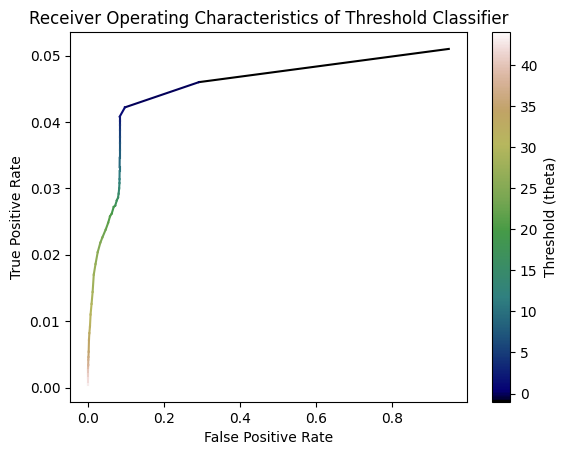

In [22]:
def plot_ROC(true_positive_rate, false_positive_rate, features, labels, hypothesis):
    """
    Plot the receiver operating characteristics (true positive rate vs false positive rate)
    for a given parametric hypothesis class and dataset.
    """

    tpr = [
        true_positive_rate(features, labels, hypothesis, theta)
        for theta in possible_thetas
    ]

    fpr = [
        false_positive_rate(features, labels, hypothesis, theta)
        for theta in possible_thetas
    ]

    min_theta = numpy.min(possible_thetas)
    max_theta = numpy.max(possible_thetas)

    color = matplotlib.cm.gist_earth(
        (possible_thetas - min_theta) / (max_theta - min_theta)
    )

    ax = pyplot.gca()
    for i in numpy.arange(len(possible_thetas) - 1):
        ax.plot([fpr[i], fpr[i + 1]], [tpr[i], tpr[i + 1]], c=color[i])

    cbar = pyplot.colorbar(
        matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(min_theta, max_theta), cmap=matplotlib.cm.gist_earth
        ),
        ax=ax,
    )

    cbar.set_label("Threshold (theta)")
    pyplot.title("Receiver Operating Characteristics of Threshold Classifier")
    pyplot.xlabel("False Positive Rate")
    pyplot.ylabel("True Positive Rate")

plot_ROC(true_positive_rate, false_positive_rate, X_values, Y_values, threshold_hypothesis)

### Precision-Recall Curve

Another useful way to visualize the trade-offs between different types of binary classification errors is to plot the "Precision-Recall Curve",
where "recall" is another name for true positive rate and "precision" is
$$
\Pr(Y{=}1 \mid \hat{Y}{=}1)
$$
Precision-recall curves have precision on the y-axis and recall on the x-axis.
Like ROC curves, they give us a way to visualize the trade-off between two different metrics.

Also like ROC, more area under the curve is better and there is a metric for how much area is under the curve: Area Under the Precision-Recall Curve (AuPRC).

**This step depends on most of the previous tasks.**

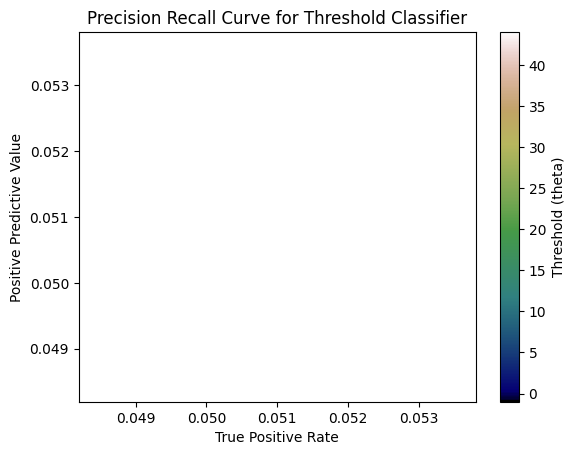

In [18]:
def precision(features, labels, hypothesis, theta):
    """
    Returns Pr(Y = 1 | Ŷ = 1) or numpy.nan if undefined for given hypothesis and theta.
    """

    tp = true_positive_fraction(features, labels, hypothesis, theta)
    fp = false_positive_fraction(features, labels, hypothesis, theta)

    pp = tp + fp

    if (pp == 0):
        return numpy.nan

    return tp / pp

def plot_precision_recall(true_positive_rate, precision, features, labels, hypothesis):
    """
    Plot precision vs recall (positive predictive value vs true positive rate)
    for a given parametric hypothesis class and dataset.
    """

    tpr = [
        true_positive_rate(features, labels, hypothesis, theta)
        for theta in possible_thetas
    ]
    pp = [precision(features, labels, hypothesis, theta) for theta in possible_thetas]

    min_theta = numpy.min(possible_thetas)
    max_theta = numpy.max(possible_thetas)

    color = matplotlib.cm.gist_earth(
        (possible_thetas - min_theta) / (max_theta - min_theta)
    )

    ax = pyplot.gca()
    for i in numpy.arange(len(possible_thetas) - 1):
        ax.plot([tpr[i], tpr[i + 1]], [pp[i], pp[i + 1]], c=color[i])

    cbar = pyplot.colorbar(
        matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(min_theta, max_theta), cmap=matplotlib.cm.gist_earth
        ),
        ax=ax,
    )

    cbar.set_label("Threshold (theta)")
    pyplot.title("Precision Recall Curve for Threshold Classifier")
    pyplot.xlabel("True Positive Rate")
    pyplot.ylabel("Positive Predictive Value")

plot_precision_recall(true_positive_rate, precision, X_values, Y_values, threshold_hypothesis)

In general, the use of plots such as the ROC or Precision vs Recall curve is highly contextual.
For our purposes, these curves provide a useful demonstration of a truism in machine learning: there are always consequences and trade-offs.
In particular, if we think of a high true positive rate as a "good thing" while a high false positive rate is a "bad thing",
the ROC demonstrates that perfect classifiers (which would reside in the upper left corner of the ROC diagram and upper right corner of the PRC diagram) seldom exist,
and that the space is characterized by an explicit trade-off between desirable classifier behaviors.

Note that the optimal threshold value we found for accuracy is not the optimal threshold value as represented on the ROC or Precision vs Recall Curve!
Even this basic binary classification example reveals a plethora of non-trivial trade-offs.

Welcome to machine learning!